In [39]:
# Imports
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from operator import itemgetter
import math

In [84]:
# Setting Directory to the LCR Data Set.
# Then, sets up a Data Frame of the unfiltered data.
# Finally, prints out the unfiltered data as a table.
os.getcwd()
os.chdir('/Users/glatiolait/Documents/LCR/LCR_files+scripts')
table = "new_db_Feb2023.csv"
opened = open(table,"r")
readed = pd.read_csv(table, sep=",")
tablelist = list(csv.reader(readed))
data_array = np.array(readed)
df = pd.DataFrame(data_array)

In [41]:
# Prompts the User for a selection of Cadence values. 
# I accounted for possible misspellings regarding capitalization.
# If the cadence value inputted is incorrect, then an error is displayed.
# The function then takes the inputted cadence string, and filters the DataFrame table with that.

cadence = input("Input Cadence Selection. (daily, weekly, or monthly) Case Sensitive.")
if cadence not in ['daily', 'Daily', 'weekly', 'Weekly', 'monthly', 'Monthly']:
    print("Error. Invalid option")

# This section takes the user input for cadence, and then outputs a data set for a random source within that cadence value.
# The randomsource variable takes a random name from the list, so some sources may be weighted far more heavily than others.
# I am not sure if the randomness is necessary, but it allowed an easy way to test multiple graphs.
# I have also included a default source name to check against consistently.

randomsource = np.random.choice(data_array[:,1])
randomsource = '4FGL J0001.2-0747'


# Prints out which source was randomly picked. Not necessary for using the default option.
print(randomsource)

# Filters the catalogue to only randomsource, cadence, sigma values larger than 4, and photon flux values greater than their error margins.
sortedsource = np.where((data_array[:,1] == randomsource) & (data_array[:,2]==cadence) & (data_array[:,-1] >= 4) & (data_array[:,6] < data_array[:,5]))

# Displays the dataframe to ensure everything is working as intended. Will omit in the future.
pd.DataFrame(data_array[sortedsource])

4FGL J0001.2-0747


,0,1,2,3,4,5,6,7,8,9
0,22875,4FGL J0001.2-0747,daily,242179201,242438401,0.0,0.0,3.11,0.0,11.88
1,42700,4FGL J0001.2-0747,daily,244512001,244771201,0.0,0.0,1.52,0.0,22.58
2,70150,4FGL J0001.2-0747,daily,247363201,247622401,0.0,0.0,0.89,0.0,10.63
3,99125,4FGL J0001.2-0747,daily,250732801,250992001,0.0,0.0,3.81,102.0,4.2
4,126575,4FGL J0001.2-0747,daily,253843201,254102401,0.0,0.0,4.57,102.0,4.01
...,...,...,...,...,...,...,...,...,...,...
139,3702700,4FGL J0001.2-0747,daily,651456001,651715201,0.0,0.0,3.29,0.0,6.63
140,3829275,4FGL J0001.2-0747,daily,665452801,665712001,0.0,0.0,3.43,0.0,4.84
141,3847575,4FGL J0001.2-0747,daily,667526401,667785601,0.0,0.0,2.01,0.0,4.69
142,3961950,4FGL J0001.2-0747,daily,680227201,680486401,0.0,0.0,1.22,0.0,14.92


In [95]:
def ransource():
    # This function takes the user input for cadence, and then outputs a data set for a random source within that cadence value.
    # I am not sure if the randomness is necessary, but it allowed an easy way to test multiple graphs.
    
    names = df.drop_duplicates(subset=[1], inplace=False)[1]
    randomsource = np.random.choice(names)

    print(randomsource)

    # Filters the catalogue to only randomsource, cadence, sigma values larger than 4, and photon flux values greater than their error margins.
    sortedsource = np.where((data_array[:,1] == randomsource) & (data_array[:,2]==cadence) & (data_array[:,-1] >= 4) & (data_array[:,6] < data_array[:,5]))

    # Displays the dataframe to ensure everything is working as intended. Will omit in the future.
    #pd.DataFrame(data_array[sortedsource])

    # This block of code is where a majority of the plots will go.

    GraphTest = (data_array[sortedsource])
    Plot = pd.DataFrame(GraphTest)
    ysize = GraphTest.size
    x = pd.DataFrame(GraphTest[:,3]/(60*60*24*365))

    # The title displays the name of the graph, with references that will vary the cadence and name of the source.
    plt.title("Photon Flux vs " + GraphTest[0,2] + " Cadence of " + GraphTest[0,1])

    # The x-axis displays the time elapsed in seconds. I would like to convert this to be a range of years.
    plt.xlabel("Mission Elapsed Time (seconds)")

    # The y-axis displays the Photon Flux. I don't believe the numerical labels are correct, but the shape of the graph appears to be correct.
    plt.ylabel("Photon Flux (GeV ph cm^-2 s^-1)")

    # This is the actual function that plots the data. At the moment, it plots column 3 (Time) vs column 5 (Photon Flux)
    #Graph = plt.plot(Plot[3],Plot[5])
    plt.errorbar(Plot[3],Plot[5],yerr=Plot[6],fmt = 'o-')
    plt.hlines(np.mean(GraphTest[:,5]),2e8,7e8)


In [83]:
# This loop processes the entire database
# It goes through each source, and determines the average flux of the entire source, and the fraction of the flux at each of those time bins.
names = df.drop_duplicates(subset=[1], inplace=False)[1]
fmatrix = []
fractionalflux = []
for name in names:
    print(name)
    source_array = (data_array[np.where(data_array[:,1] == name)])
    averageflux = np.nanmean(source_array[:,5])

    factors = source_array[:,5]/averageflux

    fmatrix.append(factors)
    print(factors)
    fractionalflux.append((name,factors,averageflux))


pd.DataFrame(fractionalflux)

4FGL J0001.2-0747
[0.47840651163199144 nan nan ... nan nan nan]
4FGL J0001.5+2113
[nan 0.214010522094489 nan ... nan nan nan]
4FGL J0003.3-1928
[nan nan nan ... nan nan nan]
4FGL J0004.3+4614
[nan 2.9243264065148367e-07 nan ... nan nan nan]
4FGL J0004.4-4737
[1.2437021309438257e-06 nan nan ... nan nan nan]
4FGL J0004.4-4001
[nan nan nan ... nan nan nan]
4FGL J0005.9+3824
[nan nan nan ... nan nan nan]
4FGL J0007.7+4008
[nan 6.733839674910058e-11 6.310327745670432e-11 ... 1.448410797999522e-10
 nan nan]
4FGL J0009.1-5012
[nan nan nan ... nan nan nan]
4FGL J0009.3+5030
[nan 0.0006556623919185217 nan ... 0.00013925572925703117 nan nan]
4FGL J0010.6+2043
[0.16328088723929957 0.3194003320558229 nan ... 0.6187486253278721 nan nan]
4FGL J0010.6-3025
[0.8549670662665144 1.1700354305793983 nan ... nan nan nan]
4FGL J0011.4+0057
[nan 1.0574377534881103 nan ... nan nan nan]
4FGL J0014.1+1910
[nan 0.3867924809971197 0.30065092409383104 ... nan nan nan]
4FGL J0014.3-0500
[1.0150270236495984 nan 0.10

/var/folders/td/mm4slxv90412jt0yh0zz6zgw0000gp/T/ipykernel_45544/2804605246.py:7: RuntimeWarning: Mean of empty slice
  averageflux = np.nanmean(source_array[:,5])


[nan 1.0026307157635814 nan ... nan nan nan]
4FGL J1038.8-5312
[nan nan nan ... nan nan nan]
4FGL J1040.5+0617
[nan nan 0.28240993191580066 ... nan nan nan]
4FGL J1043.2+2408
[nan nan nan ... nan nan nan]
4FGL J1044.6+8053
[nan nan 0.2878024751880195 ... 0.8091050717549982 nan nan]
4FGL J1045.1-5940
[0.8007050107834985 1.2309345688164228 0.4182787369764544 ...
 0.8445246879905556 nan nan]
4FGL J1045.8-2928
[2.241193382817576 0.32035137053833146 nan ... nan nan nan]
4FGL J1047.2-5517
[nan nan nan ... nan nan nan]
4FGL J1047.2+6740
[nan nan nan ... nan nan nan]
4FGL J1047.7+7238
[nan 0.44296075004980706 0.9471437175861729 ... nan nan nan]
4FGL J1047.8-6216
[0.3990674646293523 nan 0.8743612989070078 ... nan nan nan]
4FGL J1048.4+7143
[nan nan nan ... 0.9330639030255542 nan nan]
4FGL J1049.8+1429
[nan nan nan ... nan nan nan]
4FGL J1050.1+0432
[nan nan nan ... nan nan nan]
4FGL J1051.4-3139
[nan nan nan ... nan nan nan]
4FGL J1051.6+3253
[nan nan nan ... nan nan nan]
4FGL J1051.6+2109
[nan

,0,1,2
0,4FGL J0001.2-0747,"[0.47840651163199144, nan, nan, 0.453782647062...",5.685541e-08
1,4FGL J0001.5+2113,"[nan, 0.214010522094489, nan, nan, 0.328481266...",1.205548e-07
2,4FGL J0003.3-1928,"[nan, nan, nan, nan, 0.1846936732730173, nan, ...",5.630945e-08
3,4FGL J0004.3+4614,"[nan, 2.9243264065148367e-07, nan, nan, nan, n...",2.718575e-01
4,4FGL J0004.4-4737,"[1.2437021309438257e-06, nan, nan, nan, 1.4279...",8.683751e-02
...,...,...,...
1520,4FGL J2358.0-4601,"[0.03901993860762537, nan, nan, nan, 0.0334298...",1.806769e-06
1521,4FGL J2358.3-1021,"[0.6237698850232083, 0.611368893273244, nan, n...",8.063871e-08
1522,4FGL J2358.3+3830,"[nan, nan, nan, 4.6259745718748003e-10, nan, n...",5.209713e+01
1523,4FGL J2359.0+3922,"[nan, 6.4622068363381e-10, nan, nan, nan, 2.42...",3.002070e+01


In [33]:
# This is just for making the files look nicer. I dont believe that this will affect the actual arrays.
fractionalflux=pd.DataFrame(fractionalflux).rename(columns={0: 'source_name', 1: 'flux_values',2: 'average_flux'})
fractionalflux.to_csv(r'/Users/glatiolait/Documents/Exports/monthly_fluxFeb2023.csv')


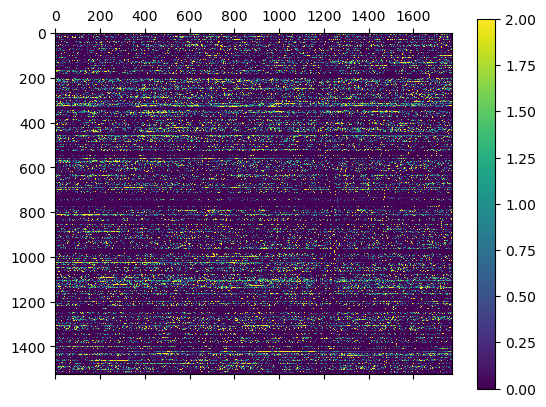

In [46]:
# This section plots each fractional point as a color-coded
fmatrix=np.array(fmatrix)
fmatrix = np.nan_to_num(fmatrix.astype(np.float64), nan=0.0)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(fmatrix, interpolation='nearest')
fig.colorbar(cax)
cax.set_clim(0,2)


In [38]:
fmatrix = np.nan_to_num(fmatrix.astype(np.float64), nan=0.0)

In [80]:
def fvar(flux,flux_err):
	#Based on Equation (34) from K. K. Singh & P. J. Meintjes, Astronomische Nachrichten, Volume 341, Issue 713, pp. 713-725
	#Error calculated with Equation (37) of the same paper

	N=len(flux)
	variance=np.nanvar(flux) #variance
	mean_squared_error=(1/N)*np.nansum(flux_err**2)
	mean_flux=np.nanmean(flux)

	num=variance-mean_squared_error
	den=mean_flux**2

	fvar=np.sqrt(num/den)

	fvar_err=np.sqrt(fvar**2 + np.sqrt((2/N) * (mean_squared_error/den)**2 + (mean_squared_error/N) * (2*fvar/mean_flux)**2 )) - fvar

	return fvar,fvar_err


def fvar_percent(flux,flux_err):
	#Based on Equation (34) from K. K. Singh & P. J. Meintjes, Astronomische Nachrichten, Volume 341, Issue 713, pp. 713-725
	#Error calculated with Equation (37) of the same paper
	#Fvar value (and error) multiplied by 100 to express the fractional variability as a "percentage-scaled" value

	N=len(flux)
	variance=np.nanvar(flux) #variance
	mean_squared_error=(1/N)*np.nansum(flux_err**2)
	mean_flux=np.nanmean(flux)

	num=variance-mean_squared_error
	den=mean_flux**2

	fvar=np.sqrt(num/den)

	fvar_err=np.sqrt(fvar**2 + np.sqrt((2/N) * (mean_squared_error/den)**2 + (mean_squared_error/N) * (2*fvar/mean_flux)**2 )) - fvar

	return fvar*100,fvar_err*100

In [50]:
names = df.drop_duplicates(subset=[1], inplace=False)[1]
fmatrix = []
Esras3 = []
for name in names:
    print(name)
    source_array = (data_array[np.where(data_array[:,1] == name)])
    flux = source_array[:,5]
    flux_err = source_array[:,6]

    factors = source_array[:,5]/averageflux

    fmatrix.append(factors)
    print(factors)
    Esras3.append((name,factors,averageflux,flux,flux_err))


pd.DataFrame(Esras3)

4FGL J0001.2-0747
[0.4504572163854581 nan nan ... nan nan nan]
4FGL J0001.5+2113
[nan 0.42727191848326546 nan ... nan nan nan]
4FGL J0003.3-1928
[nan nan nan ... nan nan nan]
4FGL J0004.3+4614
[nan 1.3165937023030854 nan ... nan nan nan]
4FGL J0004.4-4737
[1.7885801238834367 nan nan ... nan nan nan]
4FGL J0004.4-4001
[nan nan nan ... nan nan nan]
4FGL J0005.9+3824
[nan nan nan ... nan nan nan]
4FGL J0007.7+4008
[nan 0.2633187404606171 0.2467578133876223 ... 0.5663837058964216 nan nan]
4FGL J0009.1-5012
[nan nan nan ... nan nan nan]
4FGL J0009.3+5030
[nan 0.7485539036993643 nan ... 0.15898489990074993 nan nan]
4FGL J0010.6+2043
[0.18879456863214053 0.3693086737277837 nan ... 0.7154320495533748 nan nan]
4FGL J0010.6-3025
[0.9257558233804084 1.2669109210841012 nan ... nan nan nan]
4FGL J0011.4+0057
[nan 1.4109909866191557 nan ... nan nan nan]
4FGL J0014.1+1910
[nan 0.37924522997158056 0.29478450189930716 ... nan nan nan]
4FGL J0014.3-0500
[1.1642331732315334 nan 0.11675453586461323 ... 0.

,0,1,2,3,4
0,4FGL J0001.2-0747,"[0.4504572163854581, nan, nan, 0.4272719184832...",6.038309e-08,"[2.72e-08, nan, nan, 2.58e-08, 1.17e-08, nan, ...","[3.3e-08, nan, nan, 2.98e-08, 1.77e-08, nan, n..."
1,4FGL J0001.5+2113,"[nan, 0.42727191848326546, nan, nan, 0.6558127...",6.038309e-08,"[nan, 2.58e-08, nan, nan, 3.96e-08, nan, nan, ...","[nan, 2.94e-08, nan, nan, 3.31e-08, nan, nan, ..."
2,4FGL J0003.3-1928,"[nan, nan, nan, nan, 0.17223364155914578, nan,...",6.038309e-08,"[nan, nan, nan, nan, 1.04e-08, nan, 3.21e-09, ...","[nan, nan, nan, nan, 1.39e-08, nan, 3.57e-09, ..."
3,4FGL J0004.3+4614,"[nan, 1.3165937023030854, nan, nan, nan, nan, ...",6.038309e-08,"[nan, 7.95e-08, nan, nan, nan, nan, 4.75e-08, ...","[nan, 5.01e-08, nan, nan, nan, nan, 5.28e-08, ..."
4,4FGL J0004.4-4737,"[1.7885801238834367, nan, nan, nan, 2.05355495...",6.038309e-08,"[1.08e-07, nan, nan, nan, 1.24e-07, nan, nan, ...","[5.52e-08, nan, nan, nan, 6.21e-08, nan, nan, ..."
...,...,...,...,...,...
1520,4FGL J2358.0-4601,"[1.1675453586461324, nan, nan, nan, 1.00027999...",6.038309e-08,"[7.05e-08, nan, nan, nan, 6.04e-08, nan, nan, ...","[4.72e-08, nan, nan, nan, 5.92e-08, nan, nan, ..."
1521,4FGL J2358.3-1021,"[0.8330146317716377, 0.8164537046986429, nan, ...",6.038309e-08,"[5.03e-08, 4.93e-08, nan, nan, nan, 4.14e-08, ...","[4.76e-08, 6.48e-08, nan, nan, nan, 3.99e-08, ..."
1522,4FGL J2358.3+3830,"[nan, nan, nan, 0.3991183424591743, nan, nan, ...",6.038309e-08,"[nan, nan, nan, 2.41e-08, nan, nan, 5.64e-09, ...","[nan, nan, nan, 2.92e-08, nan, nan, 9.93e-09, ..."
1523,4FGL J2359.0+3922,"[nan, 0.3212819852160988, nan, nan, nan, 0.120...",6.038309e-08,"[nan, 1.94e-08, nan, nan, nan, 7.27e-09, nan, ...","[nan, 2.28e-08, nan, nan, nan, 5.71e-09, nan, ..."


In [82]:
flux = Esras3[1][3]
flux_err = Esras3[1][4]
print(fvar(flux,flux_err))
print(fvar_percent(flux,flux_err))

(0.9006760935571722, 0.010974187283629422)
(90.06760935571721, 1.0974187283629422)


In [79]:
flux = np.nan_to_num(Esras3[1][3].astype(np.float64), nan=0.0)
flux_err = np.nan_to_num(Esras3[1][4].astype(np.float64), nan=0.0)
print(fvar(flux,flux_err))
print(fvar_percent(flux,flux_err))

(1.4181074692193933, 0.020333200211348768)
(141.81074692193934, 2.0333200211348768)
